## IMPORT LIBRARY

In [ ]:
# Step 1: Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


## Load Dataset

In [ ]:
# Step 2: Load dataset
# Unggah file rainfall.csv ke Google Colab (gunakan menu Files > Upload)
df = pd.read_csv('rainfall.csv')

# Tampilkan 5 data teratas
df.head()


,date,rainfall
0,2022-01-01,12.5
1,2022-01-02,8.2
2,2022-01-03,0.0
3,2022-01-04,3.7
4,2022-01-05,21.1


dawduawhdawhdiuawd


In [ ]:
# Step 3: Eksplorasi awal dan cek info data
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      119 non-null    object 
 1   rainfall  119 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


,rainfall
count,119.000000
mean,9.484034
std,6.860992
min,0.000000
25%,4.050000
50%,9.500000
75%,14.850000
max,22.400000


In [ ]:
# Step 4: Cek dan ubah format tanggal (jika ada kolom tanggal)
# Misal kolomnya bernama 'Date' atau 'Month'
# Cek nama kolom terlebih dahulu
df.columns

# Jika ada kolom waktu:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Jika tidak ada, dan hanya urutan waktu (misal: tahun saja), kita bisa buat indexnya secara manual
# df.index = pd.date_range(start='2000-01', periods=len(df), freq='M')


In [ ]:
# Step 5: Cek missing value
df.isnull().sum()

# Jika ada missing value, kita isi dengan misalnya rata-rata:
df = df.fillna(df.mean())


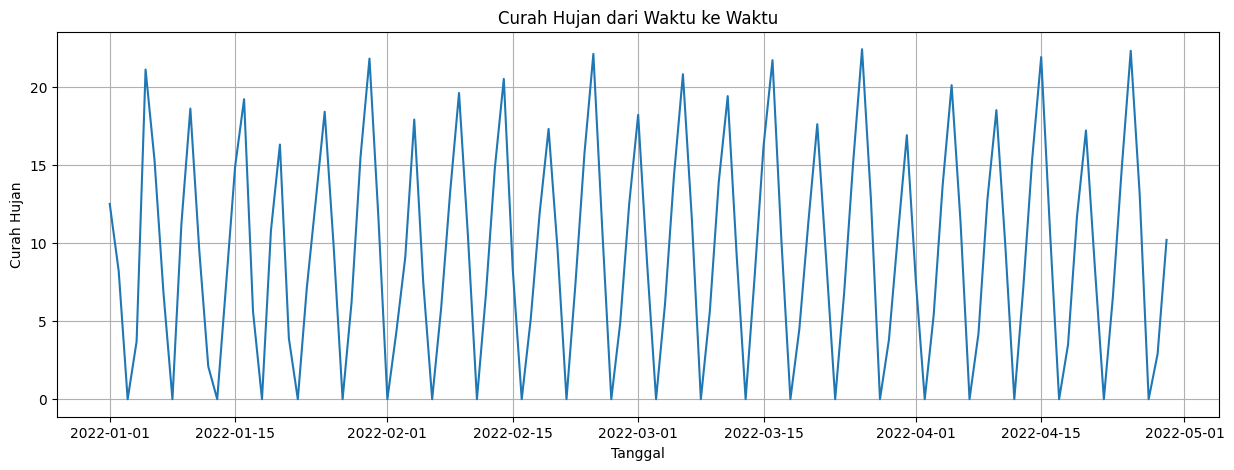

In [ ]:
# Step 6: Visualisasi data curah hujan
# Ganti 'Rainfall' dengan nama kolom yang sesuai
plt.figure(figsize=(15,5))
plt.plot(df['rainfall'])
plt.title('Curah Hujan dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan')
plt.grid()
plt.show()


In [ ]:
# Step 7: Split data untuk training dan testing
# Misal kita pakai 80% untuk training, 20% untuk test
train_size = int(len(df) * 0.8)
train, test = df['rainfall'][:train_size], df['rainfall'][train_size:]


## ARIMA

In [ ]:
# Step 8: Bangun model ARIMA
# Tentukan parameter p, d, q. Untuk awal bisa coba (5, 1, 0) atau cari pakai AIC/BIC (nanti bisa kita tuning)
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Ringkasan model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:               rainfall   No. Observations:                   95
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -240.767
Date:                Mon, 05 May 2025   AIC                            493.534
Time:                        04:25:57   BIC                            508.794
Sample:                    01-01-2022   HQIC                           499.698
                         - 04-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4544      0.176     -2.585      0.010      -0.799      -0.110
ar.L2         -0.6892      0.123     -5.620      0.000      -0.930      -0.449
ar.L3         -0.5785      0.151     -3.836      0.0

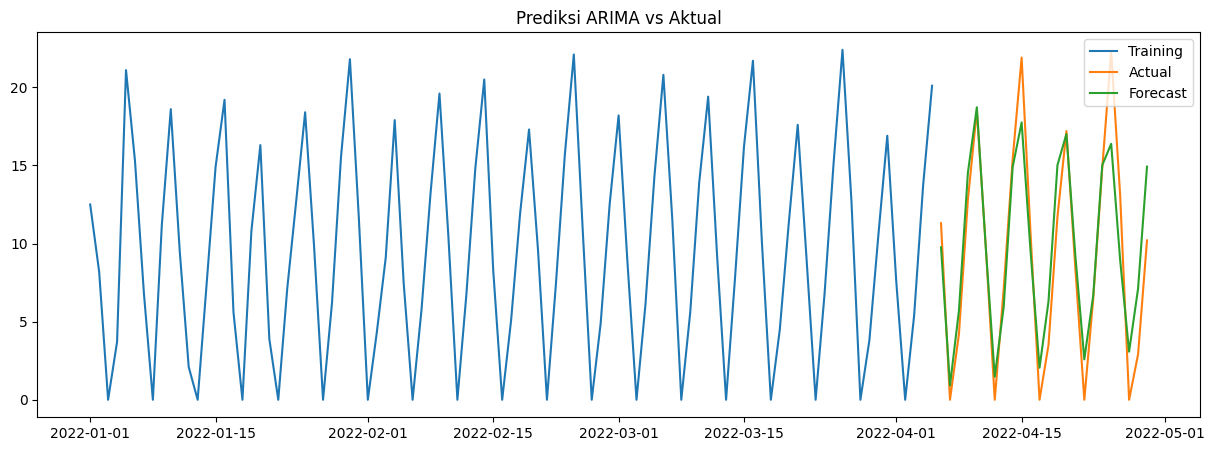

In [ ]:
# Step 9: Prediksi
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(15,5))
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Prediksi ARIMA vs Aktual')
plt.show()


In [ ]:
# Step 10: Evaluasi model
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 6.79


In [ ]:
import itertools
from statsmodels.tsa.stattools import adfuller


In [ ]:
def evaluate_arima_model(train, test, arima_order):
    try:
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        return mse, model_fit.aic, model_fit.bic
    except:
        return np.inf, np.inf, np.inf


In [ ]:
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

results = []
for p, d, q in itertools.product(p_values, d_values, q_values):
    order = (p, d, q)
    mse, aic, bic = evaluate_arima_model(train, test, order)
    results.append({'order': order, 'mse': mse, 'aic': aic, 'bic': bic})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='mse')
results_df.head(10)


,order,mse,aic,bic
19,"(2, 0, 3)",6.089809,473.821490,491.698628
27,"(3, 0, 3)",6.356035,468.359325,488.790341
26,"(3, 0, 2)",6.417510,473.112236,490.989374
18,"(2, 0, 2)",6.477011,471.298958,486.622220
23,"(2, 1, 3)",6.549579,472.375421,487.635189
30,"(3, 1, 2)",6.878040,504.107283,519.367052
22,"(2, 1, 2)",7.333970,513.006886,525.723360
31,"(3, 1, 3)",7.451500,514.497617,532.300680
25,"(3, 0, 1)",12.168105,502.229459,517.552720
29,"(3, 1, 1)",12.278437,501.075212,513.791686


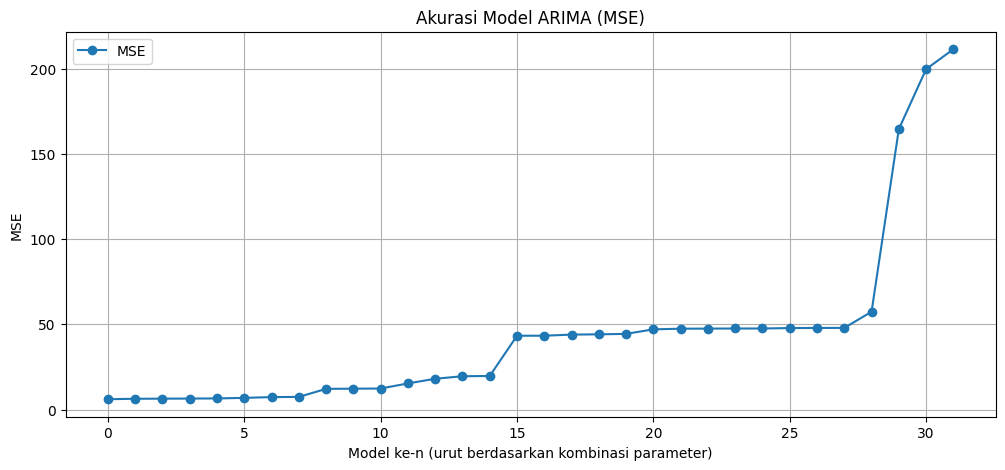

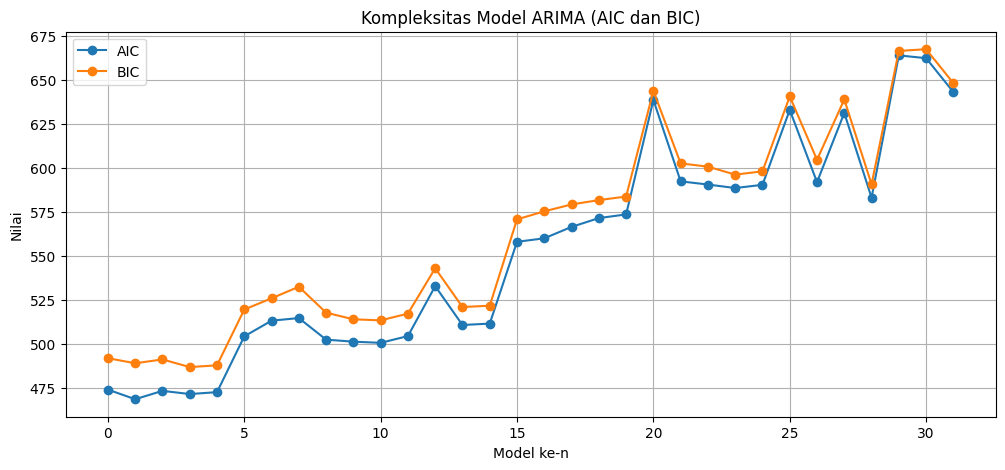

In [ ]:
# Plot MSE vs parameter
plt.figure(figsize=(12, 5))
plt.plot(results_df['mse'].values, marker='o', label='MSE')
plt.title('Akurasi Model ARIMA (MSE)')
plt.xlabel('Model ke-n (urut berdasarkan kombinasi parameter)')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

# Plot AIC & BIC
plt.figure(figsize=(12, 5))
plt.plot(results_df['aic'].values, marker='o', label='AIC')
plt.plot(results_df['bic'].values, marker='o', label='BIC')
plt.title('Kompleksitas Model ARIMA (AIC dan BIC)')
plt.xlabel('Model ke-n')
plt.ylabel('Nilai')
plt.grid()
plt.legend()
plt.show()


Best ARIMA order: (2, 0, 3)


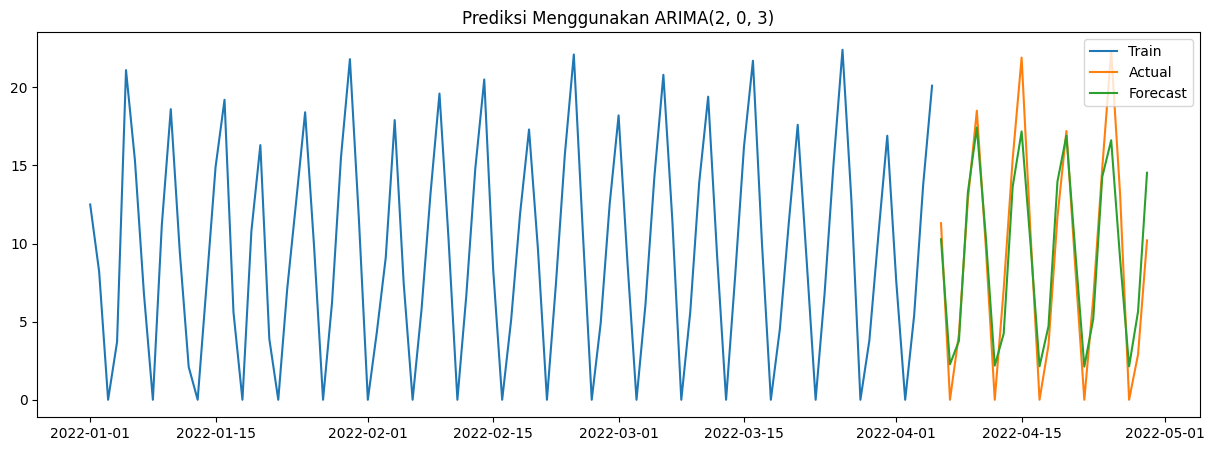

Final MSE: 6.09
AIC: 473.82, BIC: 491.70


In [ ]:
best_order = results_df.iloc[0]['order']
print(f'Best ARIMA order: {best_order}')

model = ARIMA(train, order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot final prediction vs actual
plt.figure(figsize=(15,5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.title(f'Prediksi Menggunakan ARIMA{best_order}')
plt.legend()
plt.show()

# Evaluasi akhir
final_mse = mean_squared_error(test, forecast)
print(f'Final MSE: {final_mse:.2f}')
print(f'AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}')


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0  # Hindari pembagian dengan nol
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100


In [ ]:
# Forecast akhir dengan best_order
model = ARIMA(train, order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Evaluasi metrik
final_mse = mean_squared_error(test, forecast)
final_mape = mean_absolute_percentage_error(test, forecast)
final_aic = model_fit.aic
final_bic = model_fit.bic

# Print metrik
print(f'Final MSE: {final_mse:.2f}')
print(f'Final MAPE: {final_mape:.2f}%')
print(f'AIC: {final_aic:.2f}, BIC: {final_bic:.2f}')


Final MSE: 6.09
Final MAPE: 21.12%
AIC: 473.82, BIC: 491.70


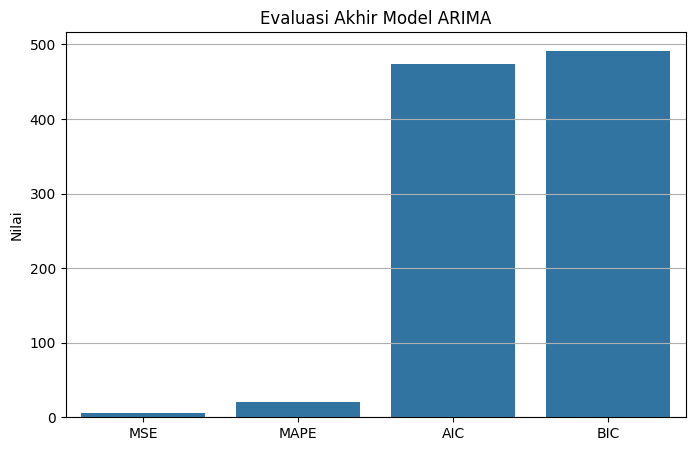

In [ ]:
# Visualisasi metrik dalam bar chart
metrics = ['MSE', 'MAPE', 'AIC', 'BIC']
values = [final_mse, final_mape, final_aic, final_bic]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values)
plt.title('Evaluasi Akhir Model ARIMA')
plt.ylabel('Nilai')
plt.grid(axis='y')
plt.show()


## PROPHET

In [ ]:
!pip install prophet statsmodels --upgrade

In [ ]:
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Untuk Prophet:
train_prophet = train.reset_index().rename(columns={'date': 'ds', 'rainfall': 'y'})
test_prophet = test.reset_index().rename(columns={'date': 'ds', 'rainfall': 'y'})

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train_prophet)
future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)[-len(test):]['yhat']

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjoikpoq/6nizu9h1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjoikpoq/atawpqjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34746', 'data', 'file=/tmp/tmphjoikpoq/6nizu9h1.json', 'init=/tmp/tmphjoikpoq/atawpqjo.json', 'output', 'file=/tmp/tmphjoikpoq/prophet_modeln3mp7jje/prophet_model-20250505042941.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:29:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## EXPONENTIAL SMOOTHING

In [ ]:
model_ets = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()  # Sesuaikan seasonal_periods jika perlu
forecast_ets = model_ets.forecast(len(test))

## EVALUASI

In [ ]:
from sklearn.metrics import mean_squared_error

# Fungsi untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0  # Hindari pembagian dengan nol
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# Hitung MSE
mse_prophet = mean_squared_error(test, forecast_prophet)
mse_ets = mean_squared_error(test, forecast_ets)

# Hitung MAPE
mape_prophet = mean_absolute_percentage_error(test, forecast_prophet)
mape_ets = mean_absolute_percentage_error(test, forecast_ets)

# Hitung AIC dan BIC (jika model mendukung)
try:
    aic_prophet = model_prophet.aic  # Ganti 'model_prophet' dengan objek model Prophet Anda
    bic_prophet = model_prophet.bic  # Ganti 'model_prophet' dengan objek model Prophet Anda
except AttributeError:
    aic_prophet = None  # Jika model Prophet tidak memiliki atribut aic/bic
    bic_prophet = None

try:
    aic_ets = model_ets.aic  # Ganti 'model_ets' dengan objek model ETS Anda
    bic_ets = model_ets.bic  # Ganti 'model_ets' dengan objek model ETS Anda
except AttributeError:
    aic_ets = None  # Jika model ETS tidak memiliki atribut aic/bic
    bic_ets = None

# Tampilkan hasil
print(f'Prophet MSE: {mse_prophet:.2f}, MAPE: {mape_prophet:.2f}%, AIC: {aic_prophet}, BIC: {bic_prophet}')
print(f'ETS MSE: {mse_ets:.2f}, MAPE: {mape_ets:.2f}%, AIC: {aic_ets}, BIC: {bic_ets}')

Prophet MSE: 48.25, MAPE: 55.74%, AIC: None, BIC: None
ETS MSE: 52.44, MAPE: 58.15%, AIC: 394.48894927834243, BIC: 435.3509795439511


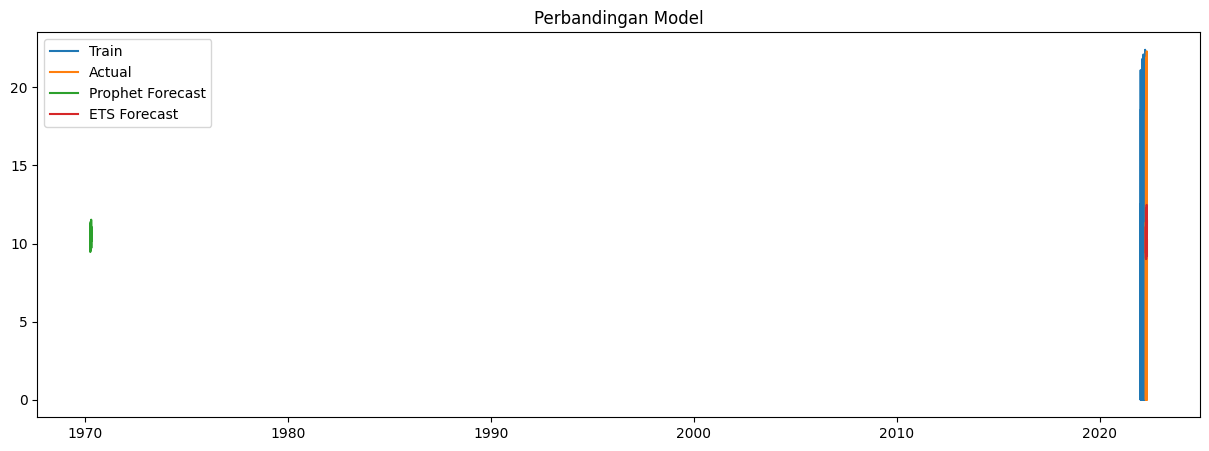

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast_prophet, label='Prophet Forecast')
plt.plot(forecast_ets, label='ETS Forecast')
plt.legend()
plt.title('Perbandingan Model')
plt.show()

Hasil Evaluasi Model:
               MSE       MAPE         AIC         BIC
ARIMA     6.089809  21.124283  473.821490  491.698628
Prophet  48.250500  55.741407         NaN         NaN
ETS      52.439696  58.146770  394.488949  435.350980


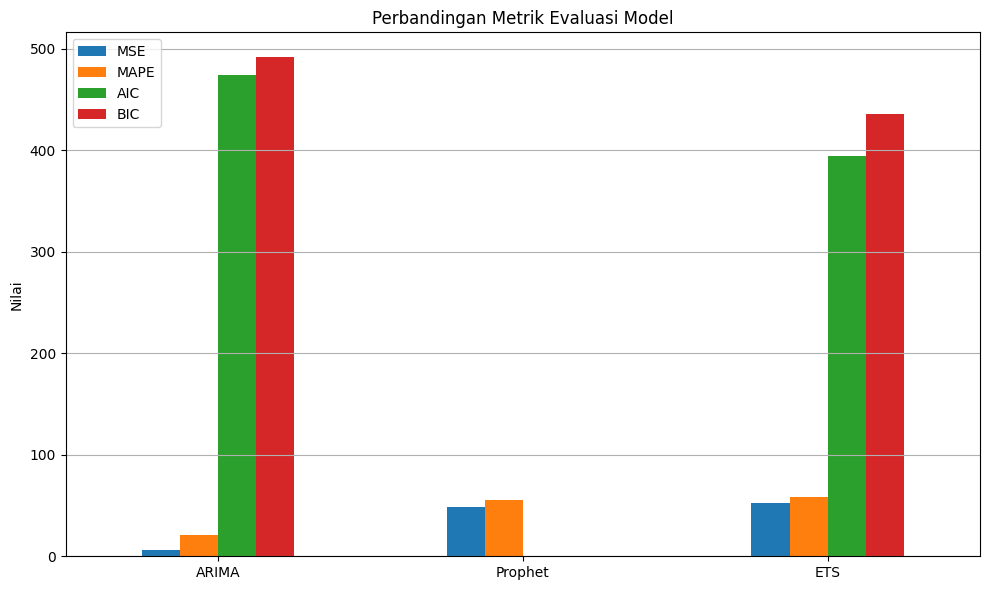


Model Terbaik untuk Setiap Metrik:
MSE     ARIMA
MAPE    ARIMA
AIC       ETS
BIC       ETS
dtype: object


In [ ]:
# Data metrik evaluasi
models = ['ARIMA', 'Prophet', 'ETS']
metrics = ['MSE', 'MAPE', 'AIC', 'BIC']
values = [[final_mse, final_mape, final_aic, final_bic],
          [mse_prophet, mape_prophet, aic_prophet, bic_prophet],
          [mse_ets, mape_ets, aic_ets, bic_ets]]

# Buat DataFrame hasil evaluasi
results_df = pd.DataFrame(values, index=models, columns=metrics)

# Tampilkan DataFrame
print("Hasil Evaluasi Model:")
print(results_df)

# Visualisasi dengan bar chart
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Metrik Evaluasi Model')
plt.ylabel('Nilai')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Mencari model terbaik untuk setiap metrik
best_model = results_df.idxmin(axis=0)
print("\nModel Terbaik untuk Setiap Metrik:")
print(best_model)